A: 0.377713761 B: 0.990277795


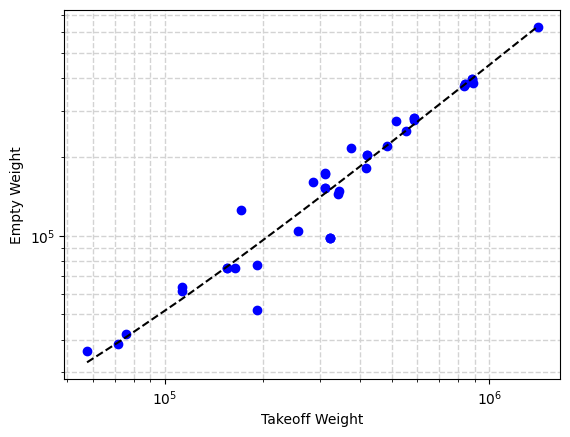

In [132]:
# Weight Regression
import numpy as np
from atmosphere import *
from tsfc import *
from conversions import *

#* Weight Regression Data
takeoff_weights = [
    154996, 836996, 342995, 584997, 57497, 256839, 112436, 892872, 286601,
    374786, 514000, 310852, 886258, 1410958, 76058, 585500, 171000, 322500,
    415000, 191800, 418878, 311734, 164000, 342100, 840000, 112436, 485017,
    585000, 840000, 886258, 310852, 311734, 191800, 322500, 418878, 551156,
    322500, 71650, 155000
]

empty_weights = [
    75561, 373999, 148118, 278003, 36343, 104168, 63934, 385809, 160497,
    216053, 275600, 173820, 399037, 628137, 42000, 282500, 126000, 98466,
    181610, 52090, 203928, 152119, 75560, 144492, 380000, 61249, 220462,
    282500, 380000, 399037, 173000, 152119, 77161, 98466, 203928, 251327,
    98392, 38581, 75562
]

aircraft_names = [
    "LM C130", "LM C5", "LM C141", "Boeing C17", "Grumman C2", "Airbus A400M",
    "Transall C160", "Antonov An124", "Antonov An70", "Ilyushin Il70", "A330 MRTT",
    "A400M-Atlas", "An-124 Ruslan", "An-225 Mriya", "An-72", "C-17 Globemaster III",
    "C-40A Clipper", "KC-135 Stratotanker", "KC-46 Pegasus", "KC-390", "IL-76",
    "Kawasaki C-2", "C-130J Hercules", "C-141 Starlifter", "C-5M Galaxy", "Transall C-160",
    "Xi'an Y-20", "C-17 Globemaster III", "C-5M Super Galaxy", "An-124 Ruslan",
    "A400M Atlas", "Kawasaki C-2", "Embraer KC-390", "C-135 Stratolifter", "Ilyushin Il-76",
    "Antonov An-22", "KC-135 Stratotanker", "C-27J Spartan", "C-130J Super Hercules"
]

#* Weight Regression:
takeoff_weights, empty_weights, aircraft_names = zip(*sorted(zip(takeoff_weights, empty_weights, aircraft_names)))
takeoff_weights, empty_weights, aircraft_names = (list(t) for t in zip(*sorted(zip(takeoff_weights, empty_weights, aircraft_names))))

empty_weights_log = np.log10(empty_weights)
takeoff_weights_log = np.log10(takeoff_weights)

import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()

# coef = np.polyfit(takeoff_weights_log, empty_weights_log, 1)
coef = np.polyfit(takeoff_weights, empty_weights, 1)
B, A = np.polyfit(empty_weights_log, takeoff_weights_log, 1)
# Hardcoding A and B since we eliminated some redundant data:
A = 0.377713761
B = 0.990277795
# m, b = np.polyfit()
poly1d_fn = np.poly1d(coef)
ax1.plot(takeoff_weights, empty_weights, 'bo', takeoff_weights, poly1d_fn(takeoff_weights), '--k')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.grid(color='#D3D3D3', linestyle='--', linewidth=1, which="both")
# ax1.set_xticks([1000, 10000, 100000, 1000000])
# ax1.set_yticks([1000, 10000, 100000, 1000000])
ax1.set_xlabel("Takeoff Weight")
ax1.set_ylabel("Empty Weight")

print(f"A: {A} B: {B}")

In [133]:
# Weight Sizing
from weightsizingsolverproj import L_D_calc

Wto_over_S = 160 # Obtained through Constraint Sizing Process

cruise_L_D_guess = 12.20

#* Mission 2
# payload_weight = 295000
# cruise_range_nm = 5000

#* Mission 1
payload_weight = 430000
cruise_range_nm = 2500

#* Ferry
# payload_weight = 0
# cruise_range_nm = 8000

cruise_alt_ft = 37000
cruise_alt_meters = cruise_alt_ft*0.3048
climb_rate_fpm = 1800
cruise_spd_mach = 0.8
climb_initial_Mach = knots_to_mach(250)
climb_above10_Mach = knots_to_mach(300)
delta_temperature = 0
cruise_TSFC = TSFC_lb_lb_hr(Mach=0.8, Altitude=35000, PowerCode=50)
climb_initial_TSFC = np.mean([TSFC_lb_lb_hr(Mach=climb_initial_Mach, Altitude=0, PowerCode=50), TSFC_lb_lb_hr(Mach=climb_initial_Mach, Altitude=10000, PowerCode=50)])
climb_above10k_TSFC = np.mean([TSFC_lb_lb_hr(Mach=climb_above10_Mach, Altitude=10000, PowerCode=50), TSFC_lb_lb_hr(Mach=climb_above10_Mach, Altitude=35000, PowerCode=50)])

# Calculating Atmospheric Conditions
result = calculate_atmosphere(cruise_alt_meters, delta_temperature)
air_density_cruise_slugs = result[3]["slugs/ft^3"]

reserve_cruise_alt_meters = 5000 * 0.3048
result = calculate_atmosphere(reserve_cruise_alt_meters, delta_temperature)
air_density_reserve_cruise_slugs = result[3]["slugs/ft^3"]

result = calculate_atmosphere(0, 15)
air_density_SL_slugs = result[3]["slugs/ft^3"]

result, vars_of_interest = L_D_calc(cruise_L_D_guess,  A, B, payload_weight, cruise_alt_ft, cruise_range_nm, cruise_spd_mach, air_density_cruise_slugs, air_density_reserve_cruise_slugs, climb_initial_TSFC, climb_above10k_TSFC, cruise_TSFC, Wto_over_S, climb_rate_fpm)
L_D_cruise_calc = result['L_D_cruise']
L_D_difference = abs(cruise_L_D_guess - L_D_cruise_calc)

while L_D_difference >= 0.00005:
    if abs(cruise_L_D_guess - L_D_cruise_calc) > .001:
        if cruise_L_D_guess > L_D_cruise_calc:
            cruise_L_D_guess -= abs(cruise_L_D_guess - L_D_cruise_calc) / 2
        else:
            cruise_L_D_guess += abs(cruise_L_D_guess - L_D_cruise_calc) / 2
        # if cruise_L_D_guess > L_D_cruise_calc:
        #     cruise_L_D_guess -= 0.001
        # else:
        #     cruise_L_D_guess += 0.001
    else:
        if cruise_L_D_guess > L_D_cruise_calc:
            cruise_L_D_guess -= 0.00001
        else:
            cruise_L_D_guess += 0.00001
    
    result, vars_of_interest = L_D_calc(cruise_L_D_guess,  A, B, payload_weight, cruise_alt_ft, cruise_range_nm, cruise_spd_mach, air_density_cruise_slugs, air_density_reserve_cruise_slugs, climb_initial_TSFC, climb_above10k_TSFC, cruise_TSFC, Wto_over_S, climb_rate_fpm)
    L_D_cruise_calc = result['L_D_cruise']
    L_D_difference = abs(cruise_L_D_guess - L_D_cruise_calc)
    
cruise_velocity_fts = result['cruise_velocity_fts']
K = result['K']
W_cruise = result['W_cruise']
W_cruise_end = result['W_cruise_end']
W_landing = result['W_landing']
takeoff_weight = result['takeoff_weight']
CL_cruise = result['CL_cruise']
S = result['S']
C_D_0 = result['C_D_0']

print('')
print("{:<15} {:<15} {:<10} {:<10} {:<10}".format("Segment", "Phase", "FF", "Weight", "Fuel Used"))
print("=" * 60)
for row in result['table_data']:
    print("{:<15} {:<15} {:<10} {:<10} {:<10}".format(row["Segment"], row["Phase"], row["FF"], row["Weight"], row["Fuel Used"]))

print('')

# Print statements
print("Converged Weight:\n---------------------")
print(f"Empty weight: {result['empty_weight']}")
print(f"Allowable empty weight: {result['empty_weight_allowable']}")
print(f"Takeoff Weight: {result['takeoff_weight']}")
print(f"Fuel weight: {result['fuel_weight']}")
print('')
print('Cruise L/D Calculations:\n---------------------')
print(f"Cruise C_L: {result['CL_cruise']}")
print(f"Cruise C_D: {result['CD_cruise']}")
print(f"Cruise L/D: {result['L_D_cruise']}")


Segment         Phase           FF         Weight     Fuel Used 
1               Start           0.99       1323340.35 13367.074 
2               Taxi            0.995      1316723.65 6616.702  
3               Takeoff         0.995      1310140.03 6583.618  
4               Climb to 10kft  0.9973     1306660.37 3479.654  
5               Climb to 35kft  0.9924     1296793.43 9866.94   
6               Cruise          0.8805     1141834.94 154958.492
7               Descent         0.99       1130416.59 11418.349 
8               Reserve Cruise  0.9785     1106127.49 24289.105 
9               Reserve Loiter  0.9865     1091212.54 14914.948 
10              Land            0.992      1082482.84 8729.7    

Converged Weight:
---------------------
Empty weight: 637907.4
Allowable empty weight: 637907.4
Takeoff Weight: 1336707.42
Fuel weight: 267600.02

Cruise L/D Calculations:
---------------------
Cruise C_L: 0.5329
Cruise C_D: 0.02614
Cruise L/D: 20.3826


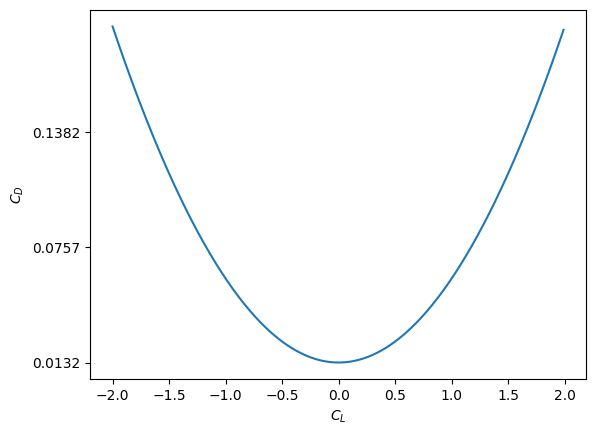

In [134]:
# Drag Polar

Cl = result['Cl']
C_D = result['C_D']
fig2, ax1 = plt.subplots()
# fig2.suptitle('Converged Drag Polar', fontsize=16)
ax1.plot(Cl, C_D)
ax1.set_ylabel(r"$C_{D}$")
ax1.set_xlabel(r"$C_{L}$")

major_ticks_x = np.arange(-2, 2.2, 0.5)

major_ticks_y = np.arange(np.min(C_D), np.max(C_D), 0.0625)

ax1.set_xticks(major_ticks_x)

ax1.set_yticks(major_ticks_y)

plt.show()

In [135]:
# General Constraint Sizing Assumptions
air_density_SL_slugs = calculate_atmosphere(0, 0)[3]['slugs/ft^3']
air_density_cruise_slugs = calculate_atmosphere(cruise_alt_meters, 0)[3]['slugs/ft^3']
air_density_takeoff_slugs = calculate_atmosphere(0, 15)[3]['slugs/ft^3']
air_density_ceiling_slugs = calculate_atmosphere(13106.4, 0)[3]['slugs/ft^3'] # 43,000 ft
air_density_10k_slugs = calculate_atmosphere(ft_to_meters(10000), 0)[3]['slugs/ft^3']

start_range = 100
end_range = 200

wing_loads = range(start_range, end_range, 1)

g0 = 32.17405

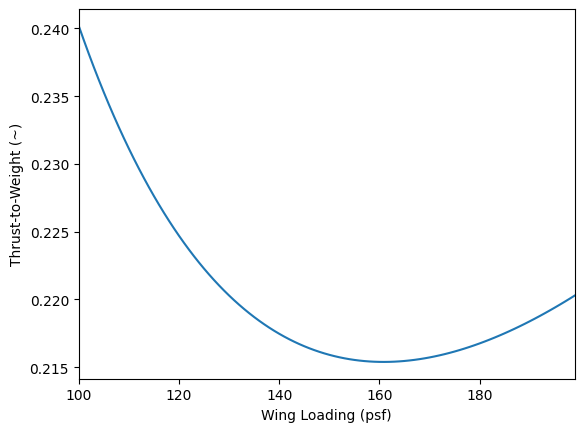

Alpha: 0.20870864750481377
Beta: 0.9121773170077863
Sigma: 0.28435216663107904


In [136]:
# Constraint Sizing - Cruise/Max
#! Key Assumptions (All Constraint Sizing):
#* Aircraft is a point mass, what are the implications of this? What is being ignored?
#* Thrust and Drag Act in Same Direction as Velocity - Is this true? Why can this assumption be made?
# Thrust Lapse - alpha - Thrust = alpha * Sea Level Thrust
# Weight Payload/Fuel Correction - beta - Weight = beta * Takeoff Weight - beta = Weight / Takeoff Weight

Ps = 0
dhdt = 0
dVdt = 0
n = 1
R = 0
h = cruise_alt_ft
V = cruise_velocity_fts
cruise_velocity_mach = ft_sec_to_mach(cruise_velocity_fts)
K1 = K
# Assumption K2 is 0 due to absence of data
K2 = 0
M = cruise_velocity_mach

sigma = air_density_cruise_slugs/air_density_SL_slugs

# Assumption - High Bypass Ratio Turbofan Engine (M < 0.9)
alpha = 0.76 * (0.568 + 0.25 * ((1.2 - M) ** 3)) * (sigma ** 0.6)

beta = W_cruise/takeoff_weight

L = n*W_cruise
# q = L/(CL_cruise*S) # Correct with minor difference
q = air_density_cruise_slugs * (cruise_velocity_fts ** 2) / 2

wing_load = takeoff_weight/S

# thrustToWeight = (beta / alpha)*(K1*(beta/q)*(wing_load) + K2 + C_D_0/((beta/q)*(wing_load)))

thrustToWeightList = []
linearTermList = []
inverseTermList = []
for wing_load in wing_loads:
    thrustToWeightList.append((beta / alpha)*(K1*(beta/q)*(wing_load) + K2 + C_D_0/((beta/q)*(wing_load))))
    linearTermList.append((beta / alpha)*(K1*(beta/q)*(wing_load)))
    inverseTermList.append((beta / alpha) * (C_D_0/((beta/q)*(wing_load))))

cruiseThrustToWeight = thrustToWeightList
    
minThrustToWeightIndex = thrustToWeightList.index(min(thrustToWeightList))

# plt.plot(wing_loads, thrustToWeightList, '-', wing_loads, linearTermList, '--', wing_loads, inverseTermList, '-.', wing_loads[minThrustToWeightIndex], thrustToWeightList[minThrustToWeightIndex], 'ro')
plt.plot(wing_loads, thrustToWeightList, '-')
plt.xlim(min(wing_loads), max(wing_loads))
# plt.legend(["Cruise", "Linear", "Inverse", "Minimum Thrust to Weight"])
plt.ylabel('Thrust-to-Weight (~)')
plt.xlabel('Wing Loading (psf)')
# plt.title("Cruise/Max")
plt.show()

print(f"Alpha: {alpha}")
print(f"Beta: {beta}")
print(f"Sigma: {sigma}")

Alpha: 0.5222382848030557
Beta: 0.98
Sigma: 0.9505195447798117
Alpha: 0.5222382848030557
Beta: 0.98
Sigma: 0.9505195447798117


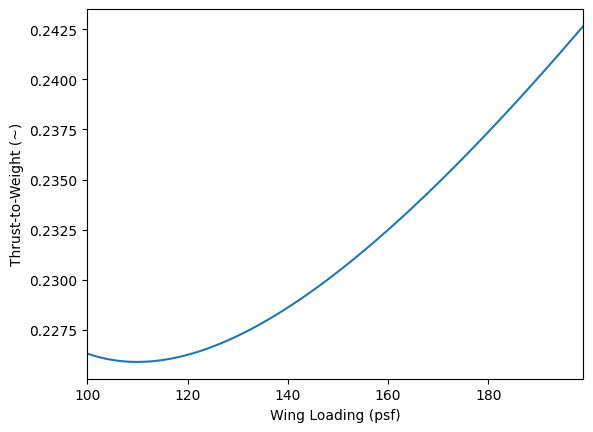

In [137]:
# Constraint Sizing - Initial Climb
def calcClimbThrustToWeights(takeoff_weight, climb_rate_fpm, climb_speed_mach, start_range, end_range, oei_factor, dhdt, sigma):
    K2 = 0 # Assumed
    dVdt = 0
    n = 1
    R = 0
    h = 0
    Ps = dhdt
    
    V = mach_to_ft_sec(climb_speed_mach)

    alpha = oei_factor * 0.76 * (0.568 + 0.25 * ((1.2 - climb_speed_mach) ** 3)) * (sigma ** 0.6)

    beta = 0.98 # assumption of some fuel burned during takeoff
    L = n*takeoff_weight
    q = air_density_takeoff_slugs * (V ** 2) / 2

    print(f"Alpha: {alpha}\nBeta: {beta}\nSigma: {sigma}")

    thrustToWeightList = []
    linearTermList = []
    inverseTermList = []
    constantTermList = []
    for wing_load in wing_loads:
        thrustToWeightList.append((beta/alpha) * (K1 * (beta/q) * (wing_load) + K2 + C_D_0/((beta/q) * (wing_load)) + (1/V) * dhdt))
        linearTermList.append((beta / alpha)*(K1*(beta/q)*(wing_load)))
        inverseTermList.append((beta/alpha) * (C_D_0/((beta/q) * (wing_load))))
        constantTermList.append((1/V) * dhdt)
    
    return thrustToWeightList, linearTermList, inverseTermList, constantTermList

sigma = air_density_takeoff_slugs/air_density_SL_slugs

thrustToWeightList, linearTermList, inverseTermList, constantTermList = calcClimbThrustToWeights(takeoff_weight, climb_speed_mach=climb_initial_Mach, climb_rate_fpm=climb_rate_fpm, start_range=start_range, end_range=end_range, oei_factor=1, dhdt=(climb_rate_fpm/60), sigma=sigma)

initialClimbThrustToWeight, _, _, _ = calcClimbThrustToWeights(takeoff_weight, climb_speed_mach=climb_initial_Mach, climb_rate_fpm=climb_rate_fpm, start_range=start_range, end_range=end_range, oei_factor=1, dhdt=(climb_rate_fpm/60), sigma=sigma)
    
minThrustToWeightIndex = thrustToWeightList.index(min(thrustToWeightList))
plt.plot(wing_loads, thrustToWeightList, '-')
# plt.plot(wing_loads, linearTermList, '--')
# plt.plot(wing_loads, inverseTermList, '-.')
# plt.plot(wing_loads, constantTermList, ':')
# plt.plot(wing_loads[minThrustToWeightIndex], thrustToWeightList[minThrustToWeightIndex], 'ro')
plt.xlim(min(wing_loads), max(wing_loads))
# plt.legend(["Climb", "Linear", "Inverse", "Constant", "Minimum Thrust to Weight"])
plt.ylabel('Thrust-to-Weight (~)')
plt.xlabel('Wing Loading (psf)')
# plt.title("Initial Climb") #! Remove in report
plt.show()

Alpha: 0.42672437801148927
Beta: 0.98
Sigma: 0.7384792985018954
Alpha: 0.42672437801148927
Beta: 0.98
Sigma: 0.7384792985018954


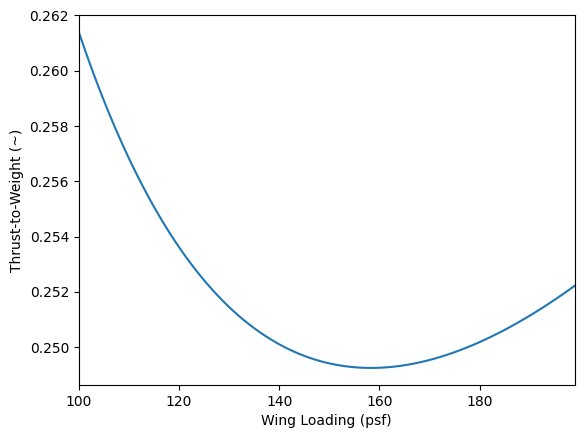

In [138]:
# Second Climb Segment
sigma = air_density_10k_slugs/air_density_SL_slugs

thrustToWeightList, linearTermList, inverseTermList, constantTermList = calcClimbThrustToWeights(takeoff_weight, climb_speed_mach=climb_above10_Mach, climb_rate_fpm=climb_rate_fpm, start_range=start_range, end_range=end_range, oei_factor=1, dhdt=(climb_rate_fpm/60), sigma=sigma)

climb_rate_fpm = 1500
finalClimbThrustToWeight, _, _, _ = calcClimbThrustToWeights(takeoff_weight, climb_speed_mach=climb_above10_Mach, climb_rate_fpm=climb_rate_fpm, start_range=start_range, end_range=end_range, oei_factor=1, dhdt=(climb_rate_fpm/60), sigma=sigma)
    
minThrustToWeightIndex = thrustToWeightList.index(min(thrustToWeightList))
plt.plot(wing_loads, thrustToWeightList, '-')
# plt.plot(wing_loads, linearTermList, '--')
# plt.plot(wing_loads, inverseTermList, '-.')
# plt.plot(wing_loads, constantTermList, ':')
# plt.plot(wing_loads[minThrustToWeightIndex], thrustToWeightList[minThrustToWeightIndex], 'ro')
plt.xlim(min(wing_loads), max(wing_loads))
# plt.legend(["Climb", "Linear", "Inverse", "Constant", "Minimum Thrust to Weight"])
plt.ylabel('Thrust-to-Weight (~)')
plt.xlabel('Wing Loading (psf)')
# plt.title("Final Climb") #! Remove in report
plt.show()

Alpha: 0.27753102276661246
Beta: 0.98
Sigma: 0.36053308847846605
Alpha: 0.27753102276661246
Beta: 0.98
Sigma: 0.36053308847846605


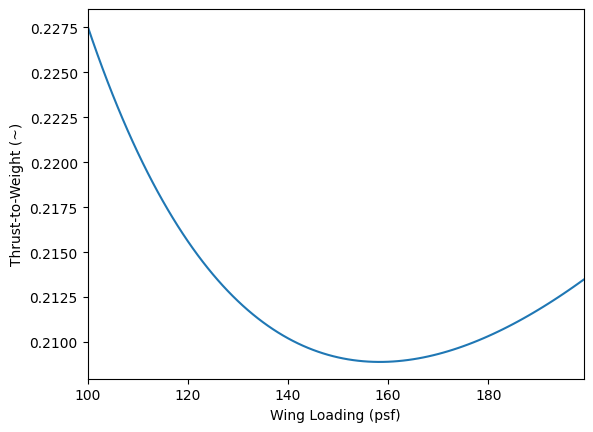

In [139]:
# Constraint Sizing - 31,000 ft 300 fpm R/C
sigma = calculate_atmosphere(ft_to_meters(31000), 0)[3]["slugs/ft^3"]/air_density_SL_slugs

thrustToWeightList, linearTermList, inverseTermList, constantTermList = calcClimbThrustToWeights(takeoff_weight, climb_speed_mach=knots_to_mach(300), climb_rate_fpm=300, start_range=start_range, end_range=end_range, oei_factor=1, dhdt=(300/60), sigma=sigma)

atAltitudeClimbThrustToWeight, _, _, _ = calcClimbThrustToWeights(takeoff_weight, climb_speed_mach=knots_to_mach(300), climb_rate_fpm=300, start_range=start_range, end_range=end_range, oei_factor=1, dhdt=(300/60), sigma=sigma)
    
minThrustToWeightIndex = thrustToWeightList.index(min(thrustToWeightList))
plt.plot(wing_loads, thrustToWeightList, '-')
# plt.plot(wing_loads, linearTermList, '--')
# plt.plot(wing_loads, inverseTermList, '-.')
# plt.plot(wing_loads, constantTermList, ':')
# plt.plot(wing_loads[minThrustToWeightIndex], thrustToWeightList[minThrustToWeightIndex], 'ro')
plt.xlim(min(wing_loads), max(wing_loads))
# plt.legend(["Climb", "Linear", "Inverse", "Constant", "Minimum Thrust to Weight"])
plt.ylabel('Thrust-to-Weight (~)')
plt.xlabel('Wing Loading (psf)')
# plt.title("31,000 ft Climb") #! Remove in report
plt.show()

Alpha: 0.3723765749001457
Beta: 0.98
Sigma: 0.9505195447798117
Alpha: 0.3723765749001457
Beta: 0.98
Sigma: 0.9505195447798117


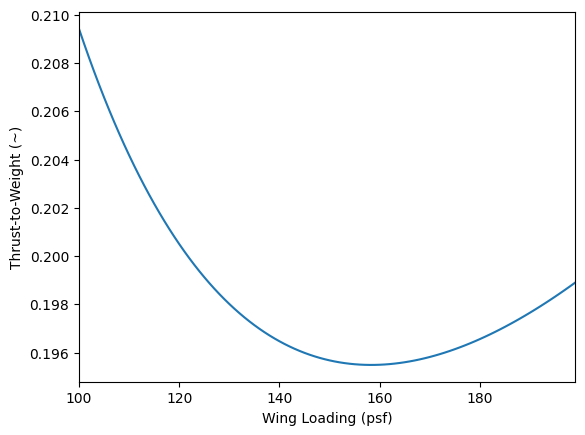

In [140]:
# Constraint Sizing - OEI Climb Gradient
sigma = air_density_takeoff_slugs/air_density_SL_slugs

thrustToWeightList, linearTermList, inverseTermList, constantTermList = calcClimbThrustToWeights(takeoff_weight, climb_speed_mach=knots_to_mach(300), climb_rate_fpm=300, start_range=start_range, end_range=end_range, oei_factor=(3/4), dhdt=(0.03 * mach_to_ft_sec(climb_initial_Mach)), sigma=sigma)

oeiClimbThrustToWeight, _, _, _ = calcClimbThrustToWeights(takeoff_weight, climb_speed_mach=knots_to_mach(300), climb_rate_fpm=300, start_range=start_range, end_range=end_range, oei_factor=(3/4), dhdt=(0.03 * mach_to_ft_sec(climb_initial_Mach)), sigma=sigma)

minThrustToWeightIndex = thrustToWeightList.index(min(thrustToWeightList))
plt.plot(wing_loads, thrustToWeightList, '-')
# plt.plot(wing_loads, linearTermList, '--')
# plt.plot(wing_loads, inverseTermList, '-.')
# plt.plot(wing_loads, constantTermList, ':')
# plt.plot(wing_loads[minThrustToWeightIndex], thrustToWeightList[minThrustToWeightIndex], 'ro')
plt.xlim(min(wing_loads), max(wing_loads))
# plt.legend(["Climb", "Linear", "Inverse", "Constant", "Minimum Thrust to Weight"])
plt.ylabel('Thrust-to-Weight (~)')
plt.xlabel('Wing Loading (psf)')
# plt.title("OEI Gradient Climb") #! Remove in report
plt.show()

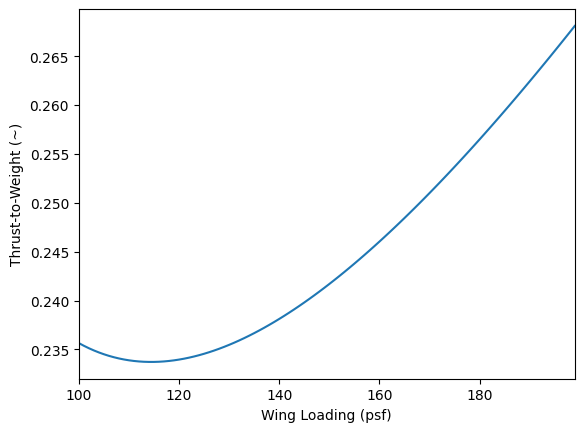

In [141]:
# Constraint Sizing - Service Ceiling
dVdt = 0
n = 1
R = 0
dhdt = 100/60 # ft/s
h = 43000
M_SC = 0.8
CL_ceil = 1

sigma = air_density_ceiling_slugs/air_density_SL_slugs

V = mach_to_ft_sec(M_SC)

q = air_density_ceiling_slugs * ( V ** 2) / 2

beta = W_cruise_end/takeoff_weight

# alpha = 0.76 * (0.568 + 0.25 * ((1.2 - M_SC) ** 3)) * (sigma ** 0.6)

thrustToWeightList = []
linearTermList = []
inverseTermList = []
constantTermList = []

for wing_load in wing_loads:
    V = np.sqrt(2 * beta * wing_load / (sigma * air_density_SL_slugs * CL_ceil))
    M_SC = ft_sec_to_mach(V)
    alpha = 0.76 * (0.568 + 0.25 * ((1.2 - M_SC) ** 3)) * (sigma ** 0.6)
    thrustToWeightList.append((beta/alpha) * ((K1 * (beta / q) * wing_load) + K2 + (C_D_0 / ((beta / q) * wing_load)) + ((1 / V) * dhdt)))
    linearTermList.append((beta / alpha)*(K1 * (beta / q) * wing_load))
    inverseTermList.append((beta/alpha) * (C_D_0 / ((beta / q) * wing_load)))
    constantTermList.append((beta/alpha) * ((1 / V) * dhdt))

serviceCeilingThrustToWeight = thrustToWeightList

minThrustToWeightIndex = thrustToWeightList.index(min(thrustToWeightList))

# plt.plot(wing_loads, thrustToWeightList, '-', wing_loads, linearTermList, '--', wing_loads, inverseTermList, '-.', wing_loads[minThrustToWeightIndex], thrustToWeightList[minThrustToWeightIndex], 'ro')
plt.plot(wing_loads, thrustToWeightList, '-')
plt.xlim(min(wing_loads), max(wing_loads))
# plt.legend(["Service Ceiling", "Linear", "Inverse", "Minimum Thrust to Weight"])
plt.ylabel('Thrust-to-Weight (~)')
plt.xlabel('Wing Loading (psf)')
# plt.title("Service Ceiling")
plt.show()

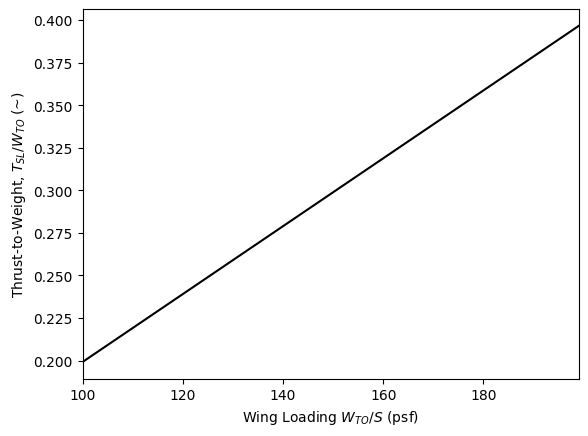

In [142]:
# Constraint Sizing - Takeoff Ground Roll (Low Thrust)
def calcTakeoffThrustToWeight(S_TO, sigma):
    # S_TO = 9000 # Takeoff Length Requirement
    C_L_max = 2.2 # Assumption for takeoff


    thrustToWeightList = []
    for wing_load in wing_loads:
        thrustToWeightList.append(37.5 * wing_load / (sigma * C_L_max * S_TO))
        
    return thrustToWeightList
        

sigma = air_density_takeoff_slugs/air_density_SL_slugs
thrustToWeightList = calcTakeoffThrustToWeight(S_TO=9000, sigma=sigma)

TOP25ThrustToWeightList = thrustToWeightList
        
minThrustToWeightIndex = thrustToWeightList.index(min(thrustToWeightList))

plt.plot(wing_loads, thrustToWeightList, '-', color='black')
# plt.legend(["T >> D", "Takeoff"])
plt.xlim(min(wing_loads), max(wing_loads))
plt.ylabel(r'Thrust-to-Weight, $T_{SL} / W_{TO}$ (~)')
plt.xlabel(r'Wing Loading $W_{TO} / S$ (psf)')
# plt.title("Takeoff Ground Roll") #! Remove in report
plt.show()

# ThrustToWeight = 37.5*(takeoff_weight/S)/(sigma * C_L_max * S_TO)
# print("Takeoff Thrust to Weight:", ThrustToWeight)

In [143]:
# Constraint Sizing - Braking Roll/Approach Speed
CL_max = 2.3
# sigma = air_density_takeoff_slugs/air_density_SL_slugs
sigma = 0.95
beta = W_landing/takeoff_weight

k_app = 1.2
V_app = knots_to_ft_sec(160)

wing_load_approach = air_density_takeoff_slugs * (V_app ** 2) * CL_max / (2 * (k_app ** 2) * beta)
print("Approach Wing Load:", wing_load_approach)

# V_app = k_app * np.sqrt((2*beta/(air_density_SL_slugs*CL_max)) * takeoff_weight/S) # ft/s
# V_app_kts = V_app * 0.592484 # ft -> kts
# print(f"Approach Speed: {np.round(V_app_kts, 1)} kts")

# S_Land = 0.3 * (V_app_kts ** 2) # For distance in ft and speed in kts
# print(f"Landing Distance: {np.round(S_Land)} ft")



Approach Wing Load: 161.18326034357398


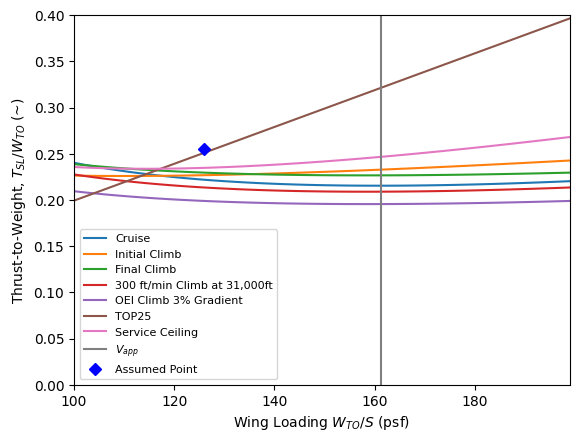

In [144]:
# Combined Constraint Plot
start_range = 0
end_range = len(wing_loads)

min_wingload = 0
max_wingload = 0.4

plt.plot(wing_loads[start_range:end_range], cruiseThrustToWeight[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], initialClimbThrustToWeight[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], finalClimbThrustToWeight[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], atAltitudeClimbThrustToWeight[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], oeiClimbThrustToWeight[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], TOP25ThrustToWeightList[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], serviceCeilingThrustToWeight[start_range:end_range])
plt.plot([wing_load_approach, wing_load_approach], [min_wingload, max_wingload])
plt.plot(126, 0.255, 'bD')
plt.legend(["Cruise", "Initial Climb", "Final Climb", "300 ft/min Climb at 31,000ft", "OEI Climb 3% Gradient", "TOP25", "Service Ceiling", r"$V_{app}$", "Assumed Point"], fontsize="8")
plt.xlim(wing_loads[start_range], wing_loads[end_range - 1])
plt.ylim(min_wingload, max_wingload)
plt.ylabel(r'Thrust-to-Weight, $T_{SL} / W_{TO}$ (~)')
plt.xlabel(r'Wing Loading $W_{TO} / S$ (psf)')
plt.show()

Alpha: 0.42672437801148927
Beta: 0.98
Sigma: 0.7384792985018954
Alpha: 0.42672437801148927
Beta: 0.98
Sigma: 0.7384792985018954


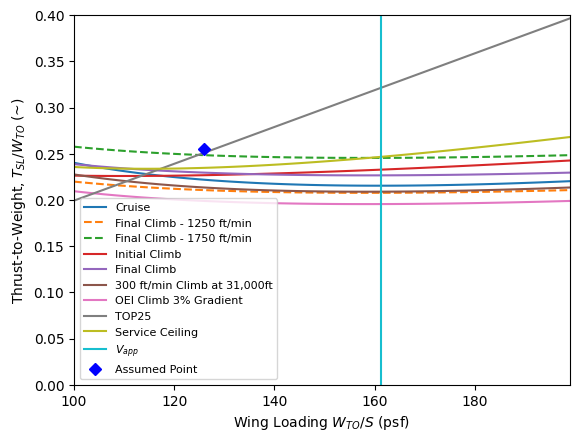

In [145]:
# Trade Study - Final Climb Rate
sigma = air_density_10k_slugs/air_density_SL_slugs
climb_rate_fpm = 1250
finalClimbThrustToWeight1500, _, _, _ = calcClimbThrustToWeights(takeoff_weight, climb_speed_mach=climb_above10_Mach, climb_rate_fpm=climb_rate_fpm, start_range=start_range, end_range=end_range, oei_factor=1, dhdt=(climb_rate_fpm/60), sigma=sigma)
climb_rate_fpm = 1750
finalClimbThrustToWeight1750, _, _, _ = calcClimbThrustToWeights(takeoff_weight, climb_speed_mach=climb_above10_Mach, climb_rate_fpm=climb_rate_fpm, start_range=start_range, end_range=end_range, oei_factor=1, dhdt=(climb_rate_fpm/60), sigma=sigma)



# Combined Constraint Plot
start_range = 0
end_range = len(wing_loads)

min_wingload = 0
max_wingload = 0.4

plt.plot(wing_loads[start_range:end_range], cruiseThrustToWeight[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], finalClimbThrustToWeight1500[start_range:end_range], '--')
plt.plot(wing_loads[start_range:end_range], finalClimbThrustToWeight1750[start_range:end_range], '--')
plt.plot(wing_loads[start_range:end_range], initialClimbThrustToWeight[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], finalClimbThrustToWeight[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], atAltitudeClimbThrustToWeight[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], oeiClimbThrustToWeight[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], TOP25ThrustToWeightList[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], serviceCeilingThrustToWeight[start_range:end_range])
plt.plot([wing_load_approach, wing_load_approach], [min_wingload, max_wingload])
plt.plot(126, 0.255, 'bD')
plt.legend(["Cruise", "Final Climb - 1250 ft/min", "Final Climb - 1750 ft/min", "Initial Climb", "Final Climb", "300 ft/min Climb at 31,000ft", "OEI Climb 3% Gradient", "TOP25", "Service Ceiling", r"$V_{app}$", "Assumed Point"], fontsize="8")
plt.xlim(wing_loads[start_range], wing_loads[end_range - 1])
plt.ylim(min_wingload, max_wingload)
plt.ylabel(r'Thrust-to-Weight, $T_{SL} / W_{TO}$ (~)')
plt.xlabel(r'Wing Loading $W_{TO} / S$ (psf)')
plt.show()

Alpha: 0.42672437801148927
Beta: 0.98
Sigma: 0.7384792985018954


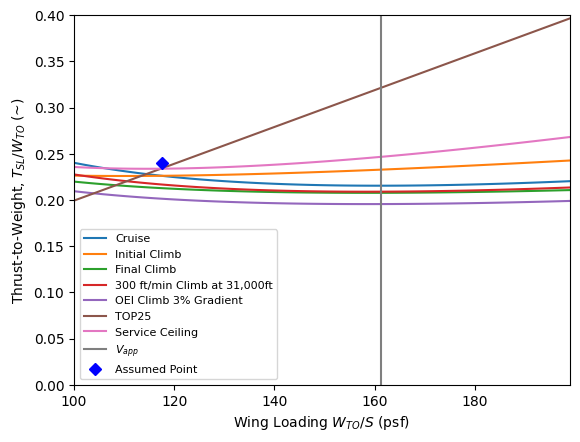

In [146]:
# Trade Study - Final Climb Rate - 1250 fpm
sigma = air_density_10k_slugs/air_density_SL_slugs
climb_rate_fpm = 1250
finalClimbThrustToWeight1250, _, _, _ = calcClimbThrustToWeights(takeoff_weight, climb_speed_mach=climb_above10_Mach, climb_rate_fpm=climb_rate_fpm, start_range=start_range, end_range=end_range, oei_factor=1, dhdt=(climb_rate_fpm/60), sigma=sigma)


# Combined Constraint Plot
start_range = 0
end_range = len(wing_loads)

min_wingload = 0
max_wingload = 0.4

plt.plot(wing_loads[start_range:end_range], cruiseThrustToWeight[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], initialClimbThrustToWeight[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], finalClimbThrustToWeight1250[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], atAltitudeClimbThrustToWeight[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], oeiClimbThrustToWeight[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], TOP25ThrustToWeightList[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], serviceCeilingThrustToWeight[start_range:end_range])
plt.plot([wing_load_approach, wing_load_approach], [min_wingload, max_wingload])
plt.plot(117.5, 0.24, 'bD')
plt.legend(["Cruise", "Initial Climb", "Final Climb", "300 ft/min Climb at 31,000ft", "OEI Climb 3% Gradient", "TOP25", "Service Ceiling", r"$V_{app}$", "Assumed Point"], fontsize="8")
plt.xlim(wing_loads[start_range], wing_loads[end_range - 1])
plt.ylim(min_wingload, max_wingload)
plt.ylabel(r'Thrust-to-Weight, $T_{SL} / W_{TO}$ (~)')
plt.xlabel(r'Wing Loading $W_{TO} / S$ (psf)')
plt.show()

Alpha: 0.5222382848030557
Beta: 0.98
Sigma: 0.9505195447798117
Alpha: 0.5222382848030557
Beta: 0.98
Sigma: 0.9505195447798117


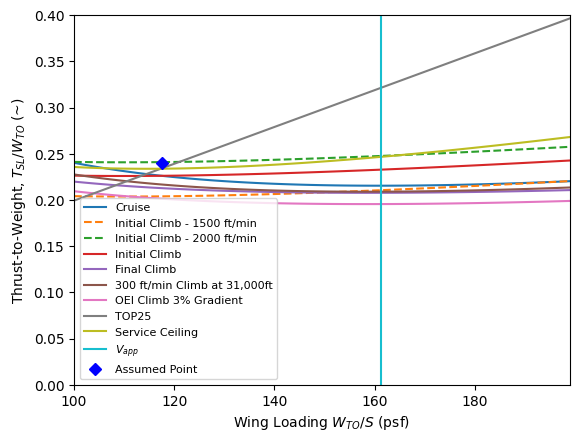

In [147]:
# Trade Study - Initial Climb Rate
sigma = air_density_takeoff_slugs/air_density_SL_slugs
climb_rate_fpm = 1500
initialClimbThrustToWeight1500, _, _, _ = calcClimbThrustToWeights(takeoff_weight, climb_speed_mach=climb_initial_Mach, climb_rate_fpm=climb_rate_fpm, start_range=start_range, end_range=end_range, oei_factor=1, dhdt=(climb_rate_fpm/60), sigma=sigma)
climb_rate_fpm = 2000
initialClimbThrustToWeight2000, _, _, _ = calcClimbThrustToWeights(takeoff_weight, climb_speed_mach=climb_initial_Mach, climb_rate_fpm=climb_rate_fpm, start_range=start_range, end_range=end_range, oei_factor=1, dhdt=(climb_rate_fpm/60), sigma=sigma)



# Combined Constraint Plot
start_range = 0
end_range = len(wing_loads)

min_wingload = 0
max_wingload = 0.4

plt.plot(wing_loads[start_range:end_range], cruiseThrustToWeight[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], initialClimbThrustToWeight1500[start_range:end_range], '--')
plt.plot(wing_loads[start_range:end_range], initialClimbThrustToWeight2000[start_range:end_range], '--')
plt.plot(wing_loads[start_range:end_range], initialClimbThrustToWeight[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], finalClimbThrustToWeight1250[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], atAltitudeClimbThrustToWeight[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], oeiClimbThrustToWeight[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], TOP25ThrustToWeightList[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], serviceCeilingThrustToWeight[start_range:end_range])
plt.plot([wing_load_approach, wing_load_approach], [min_wingload, max_wingload])
plt.plot(117.5, 0.24, 'bD')
plt.legend(["Cruise", "Initial Climb - 1500 ft/min", "Initial Climb - 2000 ft/min", "Initial Climb", "Final Climb", "300 ft/min Climb at 31,000ft", "OEI Climb 3% Gradient", "TOP25", "Service Ceiling", r"$V_{app}$", "Assumed Point"], fontsize="8")
plt.xlim(wing_loads[start_range], wing_loads[end_range - 1])
plt.ylim(min_wingload, max_wingload)
plt.ylabel(r'Thrust-to-Weight, $T_{SL} / W_{TO}$ (~)')
plt.xlabel(r'Wing Loading $W_{TO} / S$ (psf)')
plt.show()

Alpha: 0.5222382848030557
Beta: 0.98
Sigma: 0.9505195447798117


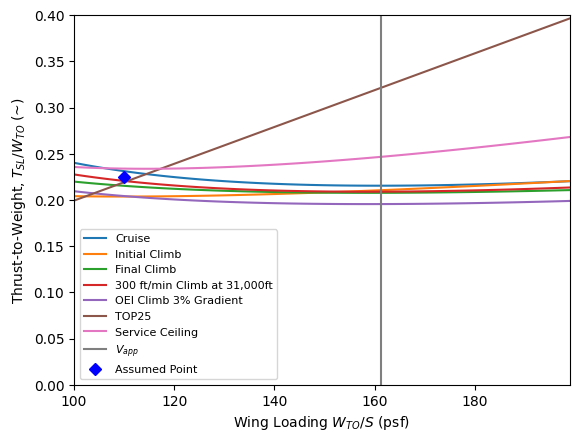

In [148]:
# Trade Study - Initial Climb Rate
sigma = air_density_takeoff_slugs/air_density_SL_slugs
climb_rate_fpm = 1500
initialClimbThrustToWeight1500, _, _, _ = calcClimbThrustToWeights(takeoff_weight, climb_speed_mach=climb_initial_Mach, climb_rate_fpm=climb_rate_fpm, start_range=start_range, end_range=end_range, oei_factor=1, dhdt=(climb_rate_fpm/60), sigma=sigma)


# Combined Constraint Plot
start_range = 0
end_range = len(wing_loads)

min_wingload = 0
max_wingload = 0.4

plt.plot(wing_loads[start_range:end_range], cruiseThrustToWeight[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], initialClimbThrustToWeight1500[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], finalClimbThrustToWeight1250[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], atAltitudeClimbThrustToWeight[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], oeiClimbThrustToWeight[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], TOP25ThrustToWeightList[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], serviceCeilingThrustToWeight[start_range:end_range])
plt.plot([wing_load_approach, wing_load_approach], [min_wingload, max_wingload])
plt.plot(110, 0.225, 'bD')
plt.legend(["Cruise", "Initial Climb", "Final Climb", "300 ft/min Climb at 31,000ft", "OEI Climb 3% Gradient", "TOP25", "Service Ceiling", r"$V_{app}$", "Assumed Point"], fontsize="8")
plt.xlim(wing_loads[start_range], wing_loads[end_range - 1])
plt.ylim(min_wingload, max_wingload)
plt.ylabel(r'Thrust-to-Weight, $T_{SL} / W_{TO}$ (~)')
plt.xlabel(r'Wing Loading $W_{TO} / S$ (psf)')
plt.show()

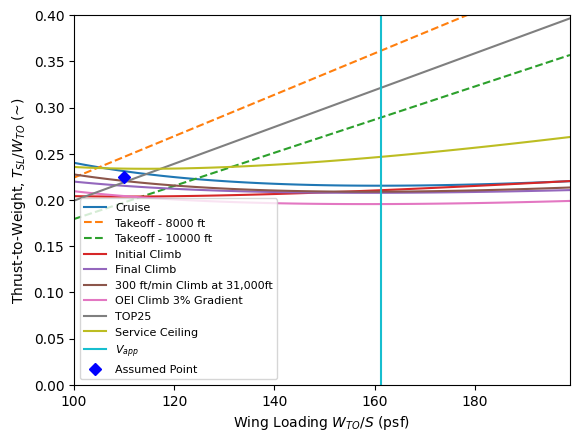

In [149]:
# Trade Study - Takeoff Field Length
sigma = air_density_takeoff_slugs/air_density_SL_slugs
TOP25ThrustToWeightList8000 = calcTakeoffThrustToWeight(S_TO=8000, sigma=sigma)
TOP25ThrustToWeightList10000 = calcTakeoffThrustToWeight(S_TO=10000, sigma=sigma)



# Combined Constraint Plot
start_range = 0
end_range = len(wing_loads)

min_wingload = 0
max_wingload = 0.4

plt.plot(wing_loads[start_range:end_range], cruiseThrustToWeight[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], TOP25ThrustToWeightList8000[start_range:end_range], '--')
plt.plot(wing_loads[start_range:end_range], TOP25ThrustToWeightList10000[start_range:end_range], '--')
plt.plot(wing_loads[start_range:end_range], initialClimbThrustToWeight1500[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], finalClimbThrustToWeight1250[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], atAltitudeClimbThrustToWeight[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], oeiClimbThrustToWeight[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], TOP25ThrustToWeightList[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], serviceCeilingThrustToWeight[start_range:end_range])
plt.plot([wing_load_approach, wing_load_approach], [min_wingload, max_wingload])
plt.plot(110, 0.225, 'bD')
plt.legend(["Cruise", "Takeoff - 8000 ft", "Takeoff - 10000 ft", "Initial Climb", "Final Climb", "300 ft/min Climb at 31,000ft", "OEI Climb 3% Gradient", "TOP25", "Service Ceiling", r"$V_{app}$", "Assumed Point"], fontsize="8")
plt.xlim(wing_loads[start_range], wing_loads[end_range - 1])
plt.ylim(min_wingload, max_wingload)
plt.ylabel(r'Thrust-to-Weight, $T_{SL} / W_{TO}$ (~)')
plt.xlabel(r'Wing Loading $W_{TO} / S$ (psf)')
plt.show()

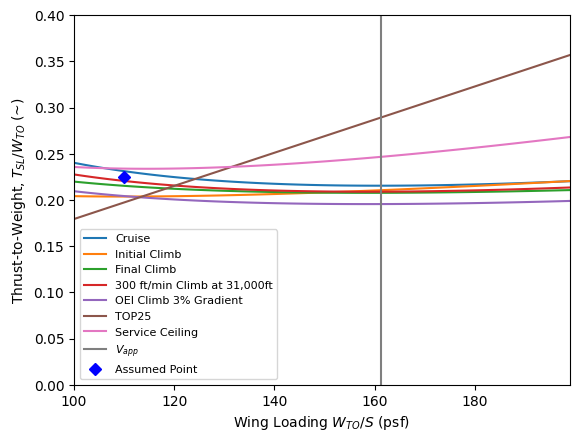

In [150]:
# Trade Study - Takeoff Field Length

# Combined Constraint Plot
start_range = 0
end_range = len(wing_loads)

min_wingload = 0
max_wingload = 0.4

plt.plot(wing_loads[start_range:end_range], cruiseThrustToWeight[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], initialClimbThrustToWeight1500[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], finalClimbThrustToWeight1250[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], atAltitudeClimbThrustToWeight[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], oeiClimbThrustToWeight[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], TOP25ThrustToWeightList10000[start_range:end_range])
plt.plot(wing_loads[start_range:end_range], serviceCeilingThrustToWeight[start_range:end_range])
plt.plot([wing_load_approach, wing_load_approach], [min_wingload, max_wingload])
plt.plot(110, 0.225, 'bD')
plt.legend(["Cruise", "Initial Climb", "Final Climb", "300 ft/min Climb at 31,000ft", "OEI Climb 3% Gradient", "TOP25", "Service Ceiling", r"$V_{app}$", "Assumed Point"], fontsize="8")
plt.xlim(wing_loads[start_range], wing_loads[end_range - 1])
plt.ylim(min_wingload, max_wingload)
plt.ylabel(r'Thrust-to-Weight, $T_{SL} / W_{TO}$ (~)')
plt.xlabel(r'Wing Loading $W_{TO} / S$ (psf)')
plt.show()